In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
mnist = fetch_mldata("MNIST original")
pca = PCA(n_components=100)
#MX = pca.fit_transform(mnist.data / 255.0)
MX = mnist.data / 255.0
My = mnist.target
#print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))

Explained total variation: , 0.9145744005218401


In [2]:
print(MX.shape)

(70000, 100)


In [3]:
rndperm = np.random.permutation(MX.shape[0])

In [4]:
def partitionData(X,y, num_points=10000, num_pivots=500):
    pivots = X[:num_pivots]
    sample_X = X[num_pivots:num_points+num_pivots]
    sample_y = y[num_pivots:num_points+num_pivots]
    return sample_X, sample_y, pivots

In [5]:
num_points = 5000
num_pivots = 500
sample_MX, sample_My, Mpivots = partitionData(MX[rndperm], My[rndperm],
                                              num_points=num_points,
                                              num_pivots=num_pivots)

In [6]:
def distanceMatrix(X,Y):
    A, _ = np.shape(X)
    B, _ = np.shape(Y)
    X2 = np.sum(X**2, axis=1).reshape(-1,1)
    Y2 = np.sum(Y**2, axis=1).reshape(-1,1)
    XY = X.dot(Y.T)
    dm = X2 - 2*XY + Y2.T
    return dm

In [7]:
M_dm = distanceMatrix(sample_MX, Mpivots)
print(M_dm.shape)

(5000, 500)


In [8]:
def kNN(dm, k=5):
    dm_arr = np.asarray(dm)
    indices = np.argsort(dm_arr, axis=1)
    sorted_dm = np.sort(dm_arr, axis=1)
    return sorted_dm[:,:k], indices[:,:k]

In [22]:
M_knn_dist, M_knn_ind = kNN(M_dm, k=5)
print(M_knn_dist.shape)
print(M_knn_dist)
print(M_knn_ind.shape)
print(M_knn_ind)

(5000, 5)
[[ 36.80310651  41.23067291  49.70248696  51.90767802  53.22741609]
 [ 38.44918422  41.66269624  42.76759582  47.94340109  49.4845905 ]
 [  4.43480112   4.87206101   5.30722481   5.43135813   6.34992882]
 ..., 
 [ 26.98660686  34.23824974  36.19798255  36.59327072  37.13832088]
 [ 22.69779432  36.20122163  38.7540538   44.09657613  44.65358737]
 [ 22.88521268  24.22212397  39.30406594  41.44214485  42.66047069]]
(5000, 5)
[[119  70 151 431 494]
 [389 191 394 164 377]
 [109 199 256 467 187]
 ..., 
 [331 436 196 177 206]
 [326 465 116 439 261]
 [175 392  59 433 220]]


In [23]:
# Co-Occurence Matrix
def coocMatrix(knn_dist, knn_ind, num_pivots=500):
    cooc_dm = np.zeros((num_pivots, num_pivots))
    N,k = knn_ind.shape
    for n in range(N):
        for i in range(k):
            for j in range(i+1,k):
                pi = knn_ind[n,i]
                pj = knn_ind[n,j]
                di = knn_dist[n, i]
                dj = knn_dist[n, j]
                r = (di+1e-10)/(dj+1e-10)
                if r > 1:
                    r = 1/r
                cooc_dm[pi,pj]+=r
                cooc_dm[pj,pi]+=r
    return cooc_dm+1

In [24]:
M_cooc_dm = coocMatrix(M_knn_dist, M_knn_ind, num_pivots)

In [25]:
print(M_cooc_dm[0])

[  1.           1.           1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.           1.           1.
   2.76236743   1.           1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.           1.           1.
   1.           1.           6.91161512   1.           1.           1.           1.
   1.           1.           1.           1.           1.           1.8710806
   1.           1.           1.           3.56312041   1.           1.           1.
   1.           1.           1.           1.           1.           1.           1.
   1.           1.84365924   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.84126487   1.
   1.93685865   1.           1.           1.           1.           1.           1.
   1.      

In [26]:
M_pivots_dm = distanceMatrix(Mpivots, Mpivots)

In [27]:
import networkx as nx

colors = ["blue", "red", "green", "yellow", "brown", "pink", "orange", "gray", "cyan", "greenyellow"]

def genGraph(knn_dist, knn_ind, pivots_dm, cooc_dm, y):
    N,k = knn_dist.shape
    P,_ = pivots_dm.shape
    cooc_pivots_dm = np.divide(pivots_dm, cooc_dm)
    G=nx.Graph()
    weighted_edges = []
    cooc_indices = np.argsort(cooc_pivots_dm)
    for i in range(P):
        for j in range(k):
            weighted_edges.append((i,cooc_indices[i,j],1/(cooc_pivots_dm[i,cooc_indices[i,j]]+1e-10)))
    
    for i in range(N):
        for j in range(k):
            weighted_edges.append((i+P,knn_ind[i,j],1/(knn_dist[i,j]+1e-10)))
        
    for i in range(N+P):
        G.add_node(i, {'color':colors[int(y[i])], 'cluster':int(y[i])})
    
    G.add_weighted_edges_from(weighted_edges)
    return G

In [28]:
MG = genGraph(M_knn_dist, M_knn_ind, M_pivots_dm, M_cooc_dm, My[rndperm])

In [29]:
print(MG.number_of_edges())

26952


In [30]:
Mpos = nx.spring_layout(MG, dim=2, iterations=100)

<IPython.core.display.Javascript object>


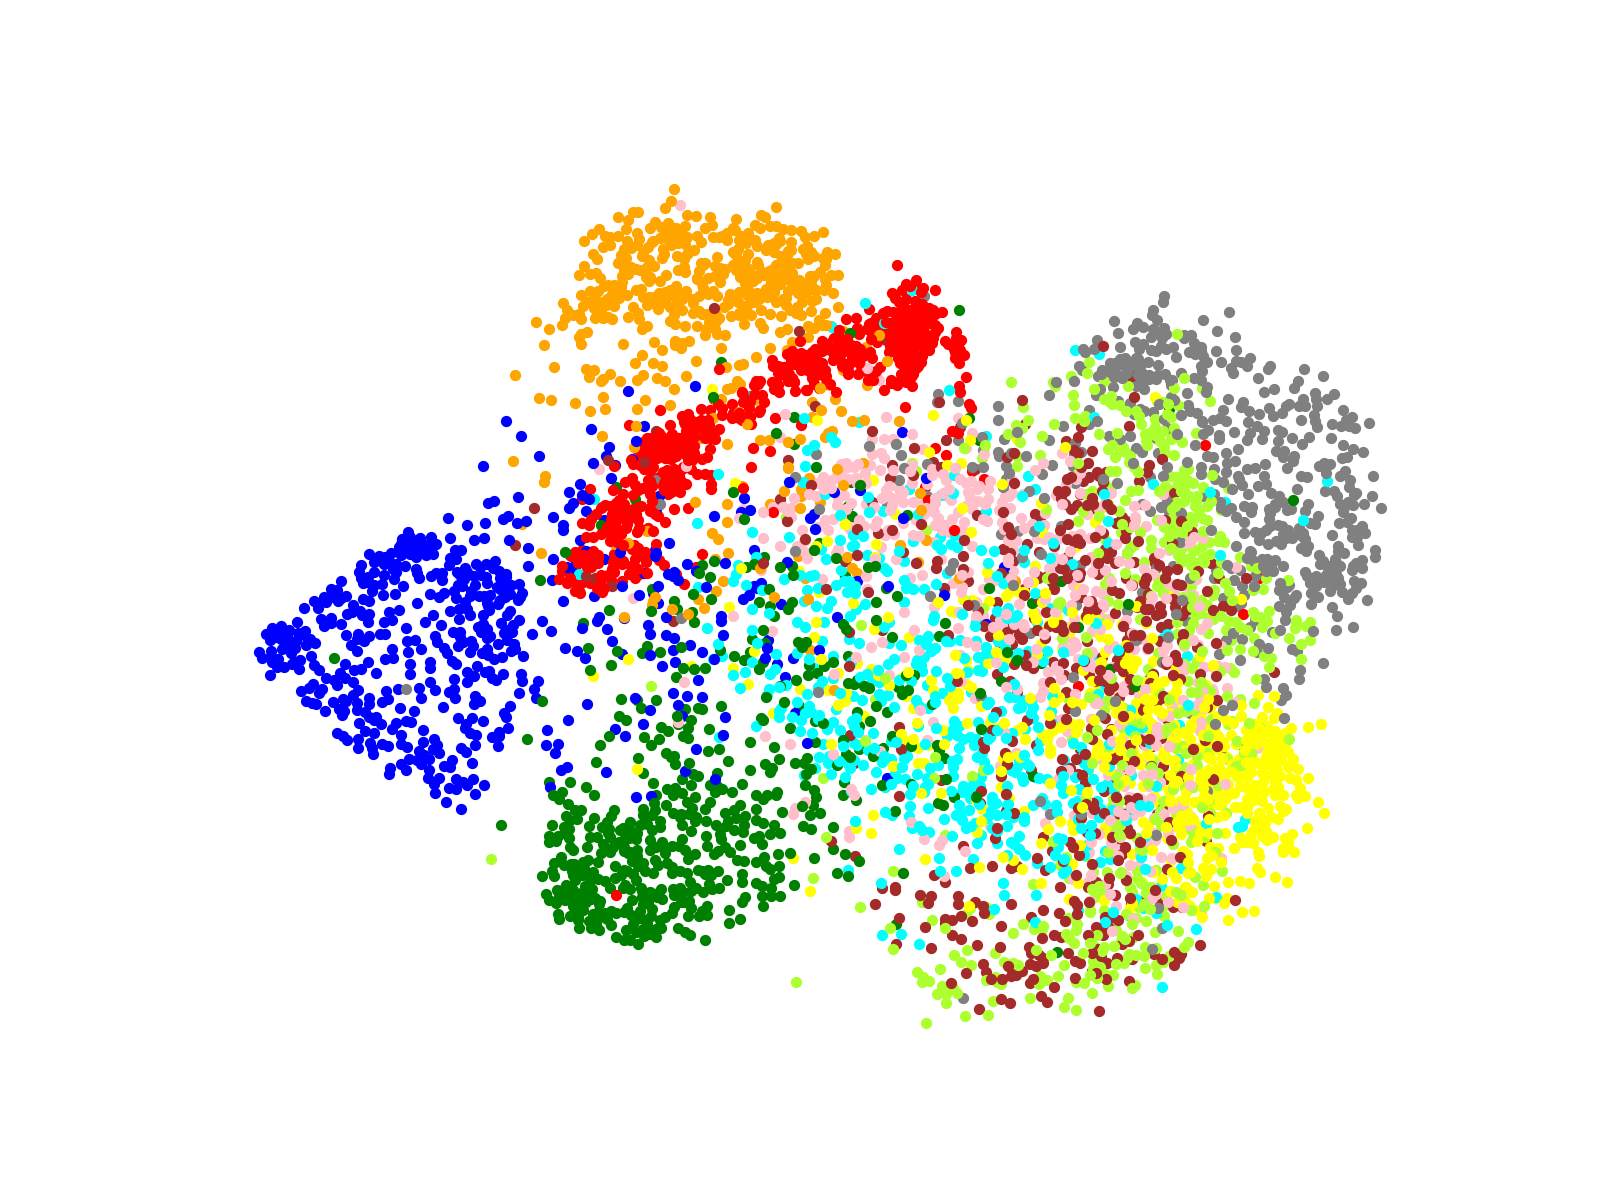

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ion()
for n in range(num_pivots+num_points):
    nx.draw_networkx_nodes(MG,Mpos, with_labels=False, nodelist=[n], node_size=5,
                           node_color=colors[int(My[rndperm][n])])
plt.axis('off')
plt.show()